In [140]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms

model1 = models.inception_v3(pretrained=True)
model1.eval()
#model2 = models.resnet152(pretrained=True)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [141]:
def get_places_model():
    arch = 'resnet18'

    # load the pre-trained weights
    model_file = '%s_places365.pth.tar' % arch
    if not os.access(model_file, os.W_OK):
        weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
        os.system('wget ' + weight_url)

    model = models.__dict__[arch](num_classes=365)
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)
    model.eval()
    
    file_name = 'categories_places365.txt'
    if not os.access(file_name, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
        os.system('wget ' + synset_url)
    classes = list()
    
    with open(file_name) as class_file:
        for line in class_file:
            classes.append(line.strip().split(' ')[0][3:])
            
    classes = tuple(classes)

    return model, classes

place_model, classes = get_places_model()

In [142]:
response = requests.get('https://s3.amazonaws.com/outcome-blog/imagenet/labels.json')
labels = {int(key): value for key, value in response.json().items()}
print(len(labels))


1000


In [143]:
print(len(classes))

365


/Users/mondormo/Desktop/test-images/1.png
/Users/mondormo/Desktop/test-images/2.png
/Users/mondormo/Desktop/test-images/3.png
/Users/mondormo/Desktop/test-images/4.png
/Users/mondormo/Desktop/test-images/5.png
/Users/mondormo/Desktop/test-images/6.png
/Users/mondormo/Desktop/test-images/7.png
/Users/mondormo/Desktop/test-images/8.png
/Users/mondormo/Desktop/test-images/9.png
/Users/mondormo/Desktop/test-images/10.png
/Users/mondormo/Desktop/test-images/11.png
/Users/mondormo/Desktop/test-images/12.png
/Users/mondormo/Desktop/test-images/13.png
/Users/mondormo/Desktop/test-images/14.png
/Users/mondormo/Desktop/test-images/15.png
/Users/mondormo/Desktop/test-images/16.png
/Users/mondormo/Desktop/test-images/17.png
/Users/mondormo/Desktop/test-images/18.png
/Users/mondormo/Desktop/test-images/19.png
/Users/mondormo/Desktop/test-images/20.png
/Users/mondormo/Desktop/test-images/21.png


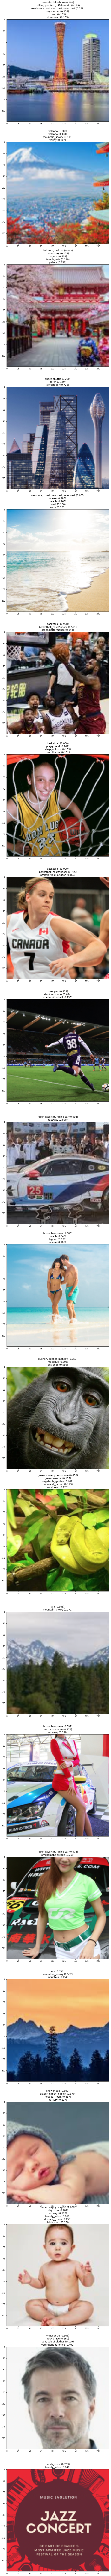

In [144]:
def predict(model, labels, input_img):
    logit = model(input_img)
    h_x = F.softmax(logit, 1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    probs, idx = probs.numpy(), idx.numpy()
    # output the prediction
    result = []
    for i in range(0, 5):
        ind = idx[i]
        if probs[i] > 0.1:
            result.append((probs[i], labels[ind]))
    return result
    

import matplotlib.pyplot as plt
import requests

% matplotlib inline

from torch.nn import functional as F
from PIL import Image
from torch.autograd import Variable

data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])


fig=plt.figure(figsize=(100, 100))
columns = 1
n_images = 22
fig.tight_layout()

for t in range(1,n_images):
    image_file = '/Users/mondormo/Desktop/test-images/'+str(t)+'.png'
    
    print(image_file)
    
    img = Image.open(image_file)    
    img = img.convert('RGB')    
    img = data_transform(img)
    
    
    ax = fig.add_subplot(n_images, columns, t)
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    
    
    
    img = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img)
    img = img.unsqueeze(0)
    input_img = Variable(img)
    

    result1 = predict(model1, labels, input_img)
    result2 = predict(place_model, classes, input_img)
    
    result = result1 + result2
    #print(result1)
    title = '\n'.join(["{} ({:.3f})".format(l, p) for p, l in result])
    ax.set_title(title)
    
    #predict(model2,labels, input_img)

plt.subplots_adjust(top=2, right=5)
plt.show()    
    


In [1]:
import os
os.path.basename('http://places2.csail.mit.edu/models_places365/_places365.pth.tar')

'_places365.pth.tar'